**Tabla de contenido**

- [Lectura de datos](#Lectura-de-datos)
- [Feature engineering](#Feature-engineering)
    - [Eliminando columnas innecesarias](#Eliminando-columnas-innecesarias)
    - [Identificando el período estacional](#Identificando-el-periodo-estacional)
    - [Dividir y escalar los datos](#Dividir-y-escalar-los-datos)
- [Preparación para el modelado con aprendizaje profundo](#Preparacion-para-el-modelado-con-aprendizaje-profundo)
    - [Configuración inicial](#Configuracion-inicial)
    - [Definición de la clase DataWindow](#Definicion-de-la-clase-DataWindow)
    - [Función de utilidad para entrenar a nuestros modelos](#Funcion-de-utilidad-para-entrenar-a-nuestros-modelos)
- [Modelado con deep Learning](#Modelado-con-deep-Learning)
    - [Modelos de referencia](#Modelos-de-referencia)
    - [Modelo lineal](#Modelo-lineal)
    - [Red neuronal profunda](#Red-neuronal-profunda)
    - [Modelo de memoria a largo y corto plazo (LSTM)](#Modelo-de-memoria-a-largo-y-corto-plazo-(LSTM))
    - [Red neuronal convolucional (CNN)](#Red-neuronal-convolucional-(CNN))
    - [Combinando una CNN con un LSTM](#Combinando-una-CNN-con-un-LSTM)
    - [El modelo LSTM autorregresivo](#El-modelo-LSTM-autorregresivo)
    - [Seleccionando el mejor modelo](#Seleccionando-el-mejor-modelo)

# Lectura de datos

In [1]:
import pandas as pd
import datetime
import os

import matplotlib.pyplot as plt
file_path = lambda file: os.path.join(os.getcwd(),'data',file)
hourly_df = pd.read_csv(file_path('clean_household_power_consumption.csv'),
                        parse_dates=['datetime'])
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


# Feature engineering

En este momento, tenemos un conjunto de datos limpio sin valores faltantes y un patrón suavizado que será más fácil de predecir utilizando técnicas de aprendizaje profundo. 

## Eliminando columnas innecesarias

El primer paso en la ingeniería de características es mostrar las estadísticas básicas para cada columna. Esto es especialmente útil para detectar si hay variables que no varían mucho. Tales variables deberían ser eliminadas, ya que si son casi constantes a lo largo del tiempo, no son predictivas de nuestro objetivo.

In [2]:
hourly_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
datetime,34587,2008-12-06 07:00:00,2006-12-16 18:00:00,2007-12-12 00:30:00,2008-12-06 07:00:00,2009-12-01 13:30:00,2010-11-26 20:00:00,NaN
Global_active_power,34587.0,64.673722,0.0,20.218,46.948,94.206,393.632,53.994006
Global_reactive_power,34587.0,7.329845,0.0,4.618,6.364,8.92,46.46,4.066731
Voltage,34587.0,14269.498306,0.0,14344.755,14455.77,14560.3,15114.12,1606.456169
Global_intensity,34587.0,274.175604,0.0,89.4,200.4,393.8,1703.0,226.090097
Sub_metering_1,34587.0,66.473964,0.0,0.0,0.0,0.0,2902.0,211.095348
Sub_metering_2,34587.0,76.936768,0.0,0.0,19.0,39.0,2786.0,250.155644


Como se puede ver, `Sub_metering_1` probablemente no sea un buen predictor para nuestro objetivo, ya que su valor constante no explicará las variaciones en la potencia activa global. Podemos eliminar esta columna con seguridad y mantener el resto.

In [3]:
hourly_df = hourly_df.drop(columns=['Sub_metering_1'], axis=1)

## Identificando el periodo estacional

Con nuestro objetivo siendo la potencia activa global en un hogar, es probable que tengamos cierta estacionalidad. Podemos esperar que por la noche se use menos energía eléctrica. De manera similar, puede haber un pico en el consumo cuando las personas regresan del trabajo durante la semana. Por lo tanto, es razonable suponer que habrá cierta estacionalidad en nuestro objetivo.

Podemos trazar nuestro objetivo para ver si podemos detectar visualmente el período.

Text(0.5, 0, 'Time')

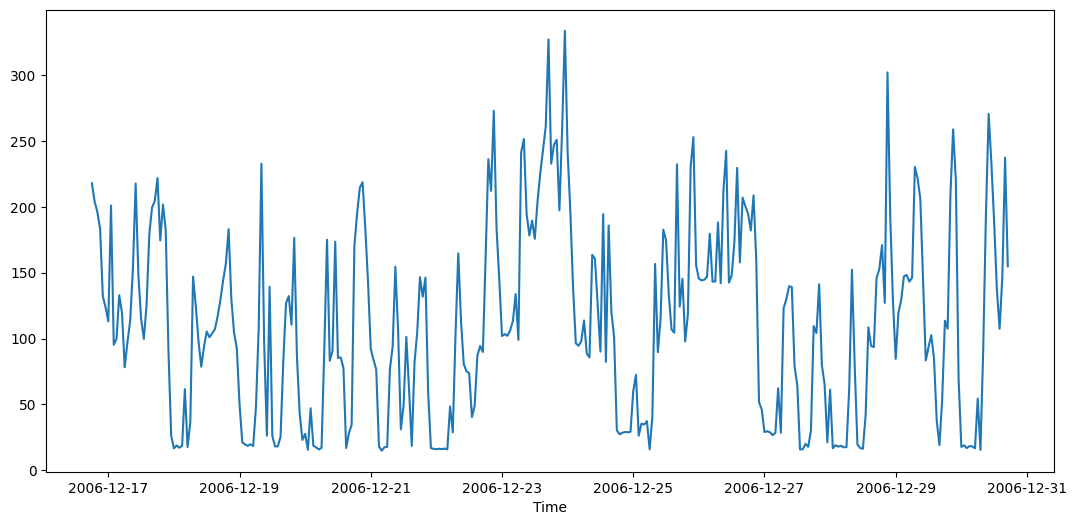

In [4]:
fig, ax = plt.subplots(figsize=(13,6))
ax.plot(hourly_df['datetime'][:336],hourly_df['Global_active_power'][:336])
ax.set_xlabel('Time')

En la figura 18.6 se puede ver que nuestro objetivo tiene un comportamiento cíclico, pero el período estacional es difícil de determinar a partir del gráfico. Si bien nuestra hipótesis sobre la estacionalidad diaria tiene sentido, debemos asegurarnos de que esté presente en nuestros datos. `Una forma de hacerlo es con una transformada de Fourier.`

Sin entrar en los detalles, una transformada de Fourier básicamente nos permite visualizar la frecuencia y la amplitud de una señal. Por lo tanto, podemos tratar nuestra serie temporal como una señal, aplicar una transformada de Fourier y encontrar las frecuencias con grandes amplitudes. Esas frecuencias determinarán el período estacional. La gran ventaja de este método es que es independiente del período estacional. Puede identificar estacionalidades anuales, semanales y diarias, o cualquier período específico que deseemos probar.

Este código calcula la Transformada Rápida de Fourier (FFT) de una señal (en este caso, Global_active_power) y luego mapea las frecuencias a ciclos por semana para facilitar el análisis de patrones temporales.

1. Aplica una transformada de Fourier en nuestro objetivo. Calcula la FFT real unilateral (solo frecuencias positivas) de los datos.
    - Resultado: Un arreglo complejo con los coeficientes de Fourier.
2. Obtén el número de frecuencias de la transformada de Fourier. Crea un array con números enteros desde 0 hasta len(fft)-1.
    - Propósito: Representa los índices de frecuencia de la FFT.
3. Descubre cuántas horas hay en el conjunto de datos. Obtiene el número total de muestras en los datos (ej. si son datos horarios, n_sample_h = cantidad de horas).
4. Obtén el número de horas en una semana. Define que una semana tiene 168 horas (útil para normalizar frecuencias).
5. Obtén el número de semanas en el conjunto de datos.
6. Obtén la frecuencia de una semana en el conjunto de datos.
7. Grafica la frecuencia y la amplitud.
8. Etiqueta las frecuencias semanales y diarias.

2025-07-17 09:51:18.527180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752763878.575627   23918 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752763878.589655   23918 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752763878.692736   23918 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752763878.692754   23918 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752763878.692756   23918 computation_placer.cc:177] computation placer alr

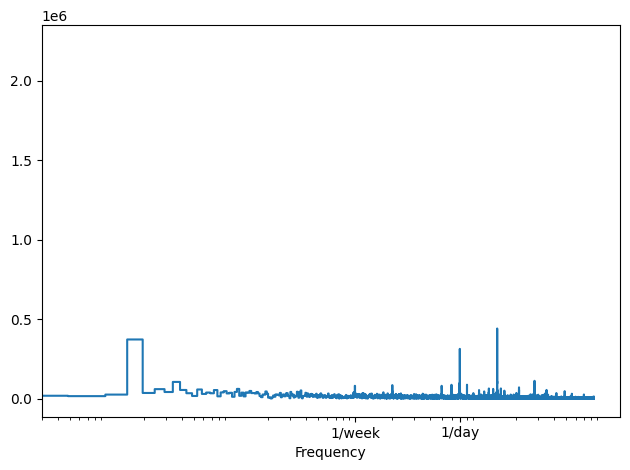

In [5]:
import tensorflow as tf
import numpy as np

fft = tf.signal.rfft(hourly_df['Global_active_power'])  #1
f_per_dataset = np.arange(0, len(fft))                  #2
n_sample_h = len(hourly_df['Global_active_power'])      #3
hours_per_week = 24 * 7                                 #4
weeks_per_dataset = n_sample_h / hours_per_week         #5
f_per_week = f_per_dataset / weeks_per_dataset          #6

plt.step(f_per_week, np.abs(fft))                       #7
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])                 #8
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()



Esto nos dice que, de hecho, tenemos estacionalidad diaria en nuestros datos. Por lo tanto, codificaremos nuestra marca de tiempo utilizando una transformación de seno y coseno para expresar el tiempo mientras mantenemos su información estacional diaria. 

In [6]:
timestamp_s =pd.to_datetime(hourly_df.datetime).map(datetime.datetime.timestamp) # convierte a segundos

In [7]:
day = 24 * 60 * 60 # convierte días a segundos
hourly_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
hourly_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
hourly_df = hourly_df.drop(['datetime'], axis=1)
hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,day_sin,day_cos
0,217.932,4.802,14074.81,936.0,403.0,-2.588190e-01,0.965926
1,204.014,5.114,13993.95,870.2,86.0,-7.065073e-12,1.000000
2,196.114,4.506,14044.29,835.0,0.0,2.588190e-01,0.965926
3,183.388,4.600,14229.52,782.8,25.0,5.000000e-01,0.866025
4,132.008,3.370,14325.60,571.4,8.0,7.071068e-01,0.707107


Nuestra ingeniería de funciones está completa y los datos están listos para escalarse y dividirse en conjuntos de capacitación, validación y prueba

## Dividir y escalar los datos


El paso final es dividir el conjunto de datos en conjuntos de entrenamiento, validación y prueba, y escalar los datos. Tenga en cuenta que primero dividiremos los datos, de modo que los escalemos utilizando solo la información del conjunto de entrenamiento, evitando así la fuga de información.

In [8]:
n = len(hourly_df)
# Split 70:20:10 (train:validation:test)
train_df = hourly_df[0:int(n*0.7)]
val_df = hourly_df[int(n*0.7):int(n*0.9)]
test_df = hourly_df[int(n*0.9):]

A continuación, ajustaremos el escalador solo al conjunto de entrenamiento y escalaremos cada conjunto individual.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df.loc[:, train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df.loc[:, val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df.loc[:, test_df.columns] = scaler.transform(test_df[test_df.columns])

# Preparacion para el modelado con aprendizaje profundo

En la última sección, producimos los tres conjuntos de datos necesarios para entrenar modelos de aprendizaje profundo. Recordemos que el objetivo de este proyecto es predecir el consumo global de energía activa en las próximas 24 horas. Esto significa que debemos construir un modelo univariado de varios pasos, ya que estamos pronosticando un solo objetivo 24 pasos en el futuro.

Construiremos dos líneas de base, un modelo lineal, un modelo de red neuronal profunda, un modelo de memoria larga a corto plazo (LSTM), una red neuronal convolucional (CNN), una combinación de CNN y LSTM, y finalmente un LSTM autorregresivo. Al final, usaremos el error absoluto medio (MAE) para determinar qué modelo es el mejor. El que logre el MAE más bajo en el conjunto de pruebas será el modelo de mayor rendimiento.

Tenga en cuenta que usaremos el MAE como métrica de evaluación y el error cuadrático medio (MSE) como función de pérdida.

## Configuracion inicial

Antes de pasar al modelado, primero necesitamos importar las bibliotecas requeridas, así como definir nuestra clase DataWindow y una función para entrenar nuestro modelos

In [10]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape,RNN, LSTMCell

tf.random.set_seed(42)
np.random.seed(42)

Finalmente, crearemos un diccionario para almacenar los nombres de las columnas y sus índices correspondientes. Esto será útil más adelante para construir los modelos de referencia y crear ventanas de datos.

In [11]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Definicion de la clase DataWindow

La clase DataWindow nos permite crear rápidamente ventanas de datos para entrenar modelos de aprendizaje profundo. Cada ventana de datos contiene un conjunto de entradas y un conjunto de etiquetas. Luego, el modelo se entrena para producir predicciones lo más cercanas posible a las etiquetas utilizando las entradas.

Una sección completa del capítulo 13 se dedicó a implementar la clase DataWindow paso a paso, y la hemos estado usando desde entonces, así que iremos directo a su implementación. El único cambio aquí será el nombre de la columna predeterminada para trazar cuando visualicemos las predicciones contra las etiquetas.


In [12]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, 
                 test_df=test_df,label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns #1
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} #2
        
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} #3

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) #4

        self.input_indices = np.arange(self.total_window_size)[self.input_slice] #5 
        self.label_start = self.total_window_size - self.label_width #6

        self.labels_slice = slice(self.label_start, None) #7 
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :] # 8
        labels = features[:, self.labels_slice, :] # 9

        if self.label_columns is not None: # 10 
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        inputs.set_shape([None, self.input_width, None]) #11 
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    # Método para trazar una muestra de ventanas de datos
    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3): # cambiar plot_col por la columna objetivo
        inputs, labels = self.sample_batch
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10) # 12
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col,None)
            else:
                label_col_index = plot_col_index
            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels',c='green', s=64) # 13
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :,label_col_index],marker='X', 
                            edgecolors='k', label='Predictions',c='red', s=64) #14
            if n == 0:
                plt.legend()
            plt.xlabel('Time (h)')
        
    # Función que crea los tensores con los datos temporales
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,                              # 15
            targets=None,                           #16
            sequence_length=self.total_window_size, #17
            sequence_stride=1,                      #18
            shuffle=True,                           #19
            batch_size=32                           #20
        )
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    """ 
    Concluiremos nuestra clase DataWindow definiendo algunas propiedades para aplicar 
    la función make_dataset en los conjuntos de entrenamiento, validación y prueba. 
    También crearemos un lote de muestra que almacenaremos en caché dentro de la clase para fines de trazado.
    """
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def sample_batch(self):                          #21
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

Con la clase DataWindow definida, solo necesitamos una función para compilar y entrenar los diferentes modelos que desarrollaremos.

## Funcion de utilidad para entrenar a nuestros modelos

Nuestro último paso antes de lanzar nuestros experimentos es crear una función que automatice el proceso de entrenamiento. Esta es la función `compile_and_fit` que hemos estado usando desde el capítulo 13.

Recuerde que esta función toma un modelo y una ventana de datos. Luego implementa la detención anticipada, lo que significa que el modelo dejará de entrenarse si la pérdida de validación no cambia durante tres épocas consecutivas. Esta es también la función en la que especificamos que la función de pérdida sea el MSE y la métrica de evaluación sea el MAE.


In [13]:
def compile_and_fit(model, window, patience=3, max_epochs=50): 
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=patience, 
                                   mode='min')
    model.compile(loss=MeanSquaredError(), 
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()]) 
    
    history = model.fit(window.train, 
                        epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping]) 
    return history

En este punto, tenemos todo lo que necesitamos para comenzar a desarrollar modelos para pronosticar las próximas 24 horas de potencia activa global.

# Modelado con deep Learning

Los conjuntos de entrenamiento, validación y prueba están listos, así como la clase DataWindow y la función que entrenará a nuestros modelos. Todo está listo para que comencemos a construir modelos de aprendizaje profundo.

Primero implementaremos dos líneas de base y luego entrenaremos modelos con complejidad creciente: un modelo lineal, una red neuronal profunda, un LSTM, un CNN, un Modelo CNN y LSTM, y un LSTM autorregresivo. Una vez que todos los modelos estén entrenados, seleccionaremos el mejor modelo comparando el MAE en el conjunto de prueba. El modelo con el MAE más bajo será el que recomendamos.

## Modelos de referencia

Cada proyecto de previsión debe comenzar con un modelo de referencia. Las líneas de base sirven como punto de referencia para nuestros modelos más sofisticados, ya que solo pueden ser mejores en comparación con un determinado punto de referencia. La creación de modelos de referencia también nos permite evaluar si la complejidad adicional de un modelo realmente genera un beneficio significativo. Es posible que un modelo complejo no funcione mucho mejor que una línea de base, en cuyo caso implementar un modelo complejo es difícil de justificar. En este caso, crearemos dos modelos de referencia: uno que repita el último valor conocido y otro que repita las últimas 24 horas de datos.

Comenzaremos creando la ventana de datos que se utilizará. Recordemos que el objetivo es pronosticar las próximas 24 horas de potencia activa global. Por lo tanto, la longitud de nuestra secuencia de etiquetas es de 24 pasos de tiempo, y el desplazamiento también será de 24 pasos de tiempo. También usaremos una longitud de entrada de 24.

In [14]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24,label_columns=['Global_active_power'])

A continuación, implementaremos una clase que repetirá el último valor conocido de la secuencia de entrada como predicción durante las próximas 24 horas.

In [15]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

Ahora podemos generar predicciones utilizando esta línea de base y almacenar su rendimiento en un diccionario. Este diccionario almacenará el rendimiento de cada modelo para que podamos compararlos al final. Tenga en cuenta que no mostraremos el MAE de cada modelo a medida que los construyamos. Compararemos las métricas de evaluación una vez que todos los modelos estén entrenados.

In [16]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Global_active_power'])
baseline_last.compile(loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test,verbose=0)

  1/215 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - loss: 0.1858 - mean_absolute_error: 0.3109

I0000 00:00:1752763882.686540   23995 service.cc:152] XLA service 0x706ef4015650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752763882.686561   23995 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2025-07-17 09:51:22.704288: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752763882.725294   23995 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752763882.854360   23995 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1769 - mean_absolute_error: 0.3036


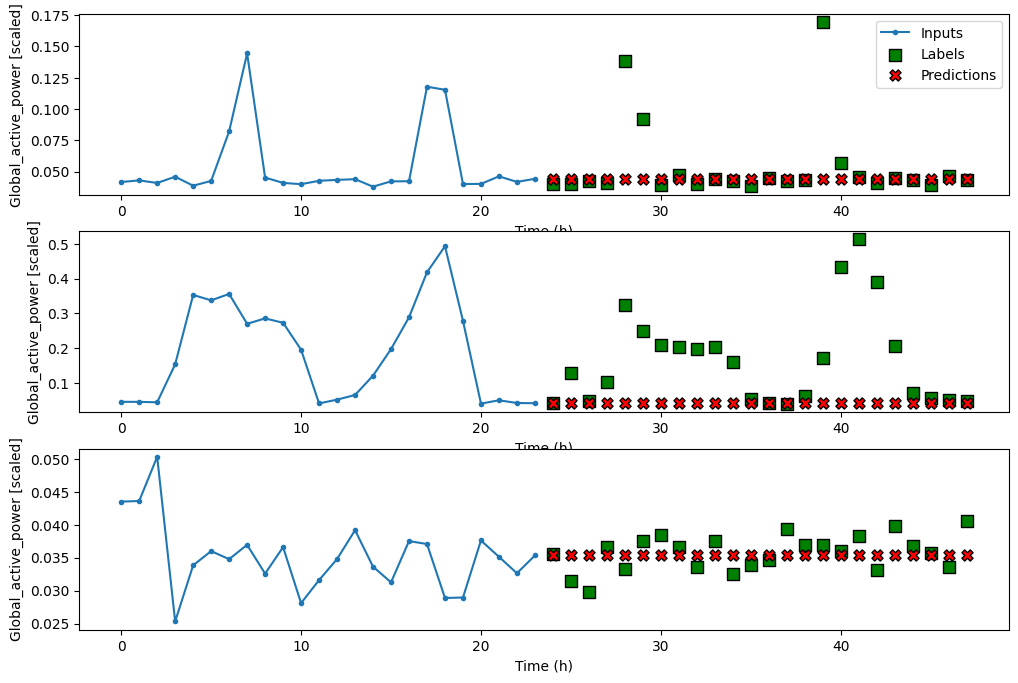

In [17]:
multi_window.plot(baseline_last)

En la figura 18.8 tenemos una línea de base de trabajo: los pronósticos corresponden a una línea plana con el mismo valor que la última entrada. Es posible que obtenga una gráfica ligeramente diferente, ya que el lote de muestra almacenado en caché utilizado para crear las gráficas puede no ser el mismo. Sin embargo, las métricas del modelo serán idénticas a las que se muestran aquí, siempre que las semillas aleatorias sean iguales.


A continuación, implementemos un modelo de línea de base que repita la secuencia de entrada. Recuerde que identificamos la estacionalidad diaria en nuestro objetivo, por lo que esto equivale a pronosticar la última temporada conocida.

In [18]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

Una vez definido, podemos generar predicciones y almacenar el rendimiento de la línea base para compararlo.

In [19]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Global_active_power'])
baseline_repeat.compile(loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1750 - mean_absolute_error: 0.2938


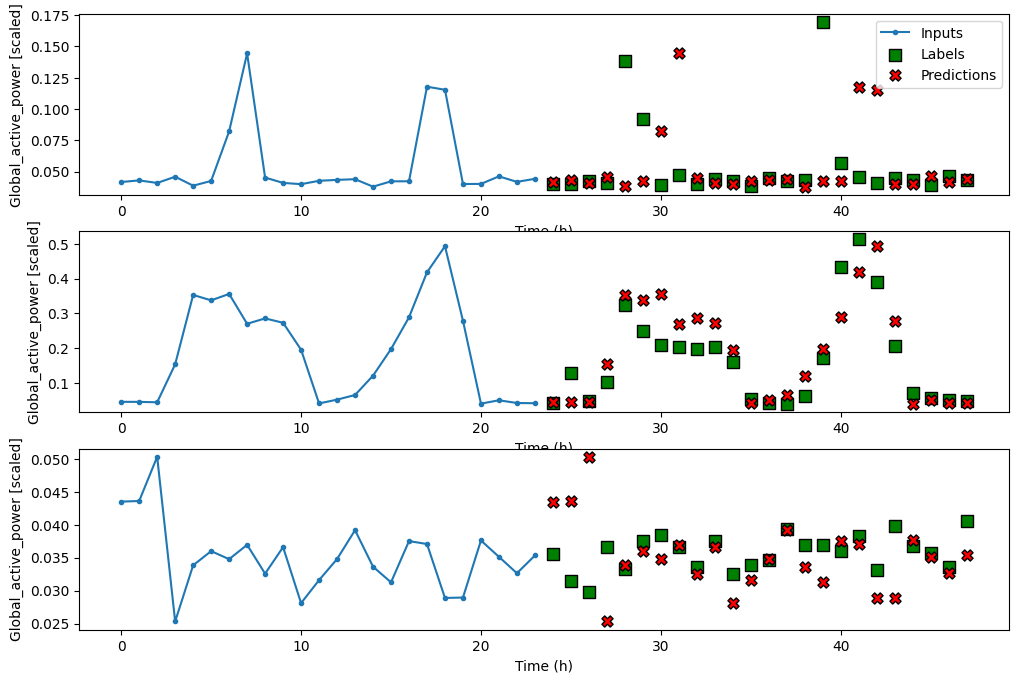

In [20]:
multi_window.plot(baseline_repeat)

En la figura 18.9, verá que las predicciones son iguales a la secuencia de entrada, que es el comportamiento esperado para este modelo de referencia. Siéntase libre de imprimir el MAE de cada modelo a medida que los construye. Los mostraré al final del capítulo en un gráfico de barras para determinar qué modelo se debe seleccionar.

Con los modelos de referencia implementados, podemos pasar al modelo lineal un poco más complejo

## Modelo lineal

Uno de los modelos más simples que podemos construir es un modelo lineal. Este modelo consta solo de una capa de entrada y una capa de salida. Por lo tanto, solo se calcula una secuencia de ponderaciones para generar predicciones lo más cercanas posible a las etiquetas.

En este caso, construiremos un modelo con una capa de salida densa que tenga solo una neurona, ya que estamos prediciendo solo un objetivo. Luego entrenaremos el modelo y almacenaremos su rendimiento.

In [21]:
label_index = column_indices['Global_active_power']
num_features = train_df.shape[1]

linear = Sequential([Dense(1, kernel_initializer=tf.initializers.zeros)])
history = compile_and_fit(linear, multi_window)
val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0207 - mean_absolute_error: 0.1091 - val_loss: 0.0131 - val_mean_absolute_error: 0.0867
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.0944 - val_loss: 0.0131 - val_mean_absolute_error: 0.0861
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0936 - val_loss: 0.0131 - val_mean_absolute_error: 0.0863
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0936 - val_loss: 0.0131 - val_mean_absolute_error: 0.0865
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0937 - val_loss: 0.0130 - val_mean_absolute_error: 0.0869
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0938 - val_loss: 0.0132 - val_mean_absolute_error: 0.0857
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0936 - v

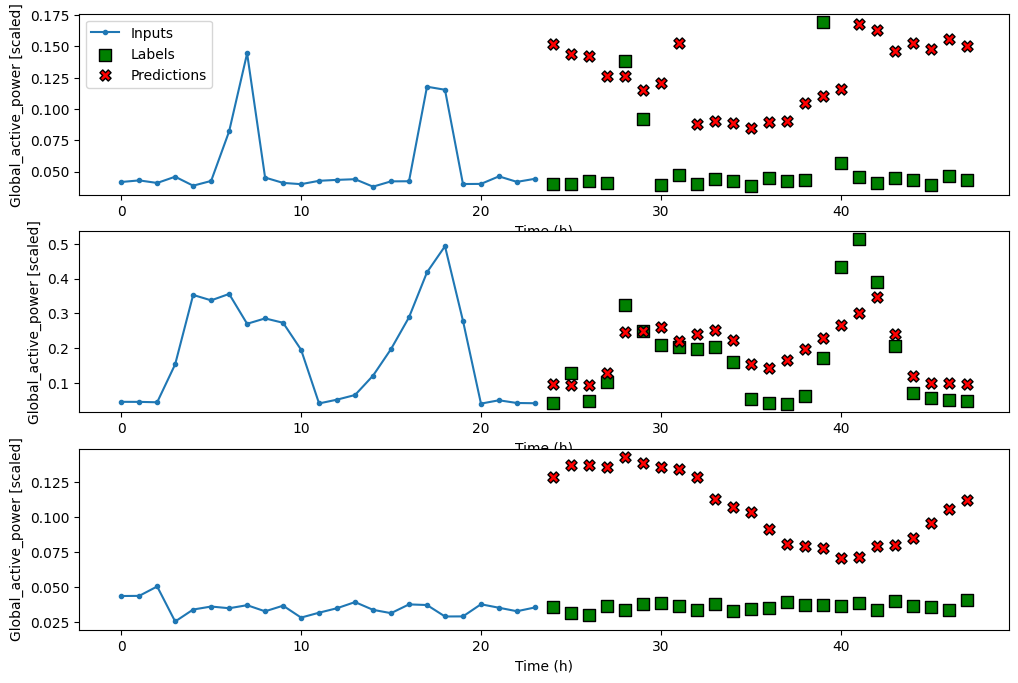

In [22]:
multi_window.plot(linear)

Ahora agreguemos capas ocultas e implementemos una red neuronal profunda.

## Red neuronal profunda

El modelo lineal anterior no tenía capas ocultas; era simplemente una capa de entrada y una capa de salida. Ahora agregaremos capas ocultas, que nos ayudarán a modelar relaciones no lineales en los datos.

Aquí apilaremos dos capas densas con 64 neuronas y usaremos ReLU como función de activación. Luego entrenaremos el modelo y almacenaremos su rendimiento para compararlo.


In [23]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)
val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0170 - mean_absolute_error: 0.0965 - val_loss: 0.0116 - val_mean_absolute_error: 0.0765
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0137 - mean_absolute_error: 0.0855 - val_loss: 0.0119 - val_mean_absolute_error: 0.0820
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - mean_absolute_error: 0.0854 - val_loss: 0.0115 - val_mean_absolute_error: 0.0772
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0135 - mean_absolute_error: 0.0844 - val_loss: 0.0113 - val_mean_absolute_error: 0.0775
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0840 - val_loss: 0.0113 - val_mean_absolute_error: 0.0772
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0838 - val_loss: 0.0112 - val_mean_absolute_error: 0.0769
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0836 - v

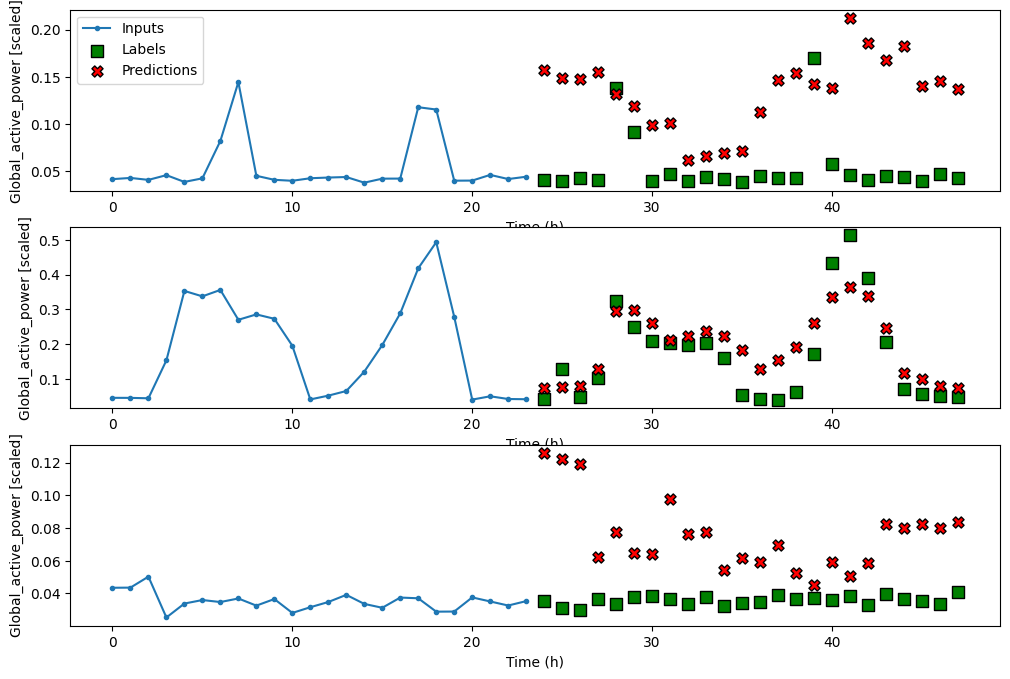

In [24]:
multi_window.plot(dense)

## Modelo de memoria a largo y corto plazo (LSTM)

La principal ventaja del modelo de memoria a largo corto plazo (LSTM) es que mantiene información del pasado en la memoria. Esto lo hace especialmente adecuado para tratar secuencias de datos, como series temporales. Nos permite combinar información del presente y del pasado para producir una predicción.

Alimentaremos la secuencia de entrada a través de una capa LSTM antes de enviarla a la capa de salida, que seguirá siendo una capa densa con una neurona. Luego entrenaremos el modelo y almacenaremos su rendimiento en el diccionario para comparación al final.

In [25]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])
history = compile_and_fit(lstm_model, multi_window)
val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0197 - mean_absolute_error: 0.1058 - val_loss: 0.0121 - val_mean_absolute_error: 0.0822
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0139 - mean_absolute_error: 0.0866 - val_loss: 0.0121 - val_mean_absolute_error: 0.0840
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0136 - mean_absolute_error: 0.0852 - val_loss: 0.0114 - val_mean_absolute_error: 0.0794
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0134 - mean_absolute_error: 0.0843 - val_loss: 0.0115 - val_mean_absolute_error: 0.0794
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0838 - val_loss: 0.0113 - val_mean_absolute_error: 0.0774
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0834 - val_loss: 0.0116 - val_mean_absolute_error: 0.0781
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0832 - v

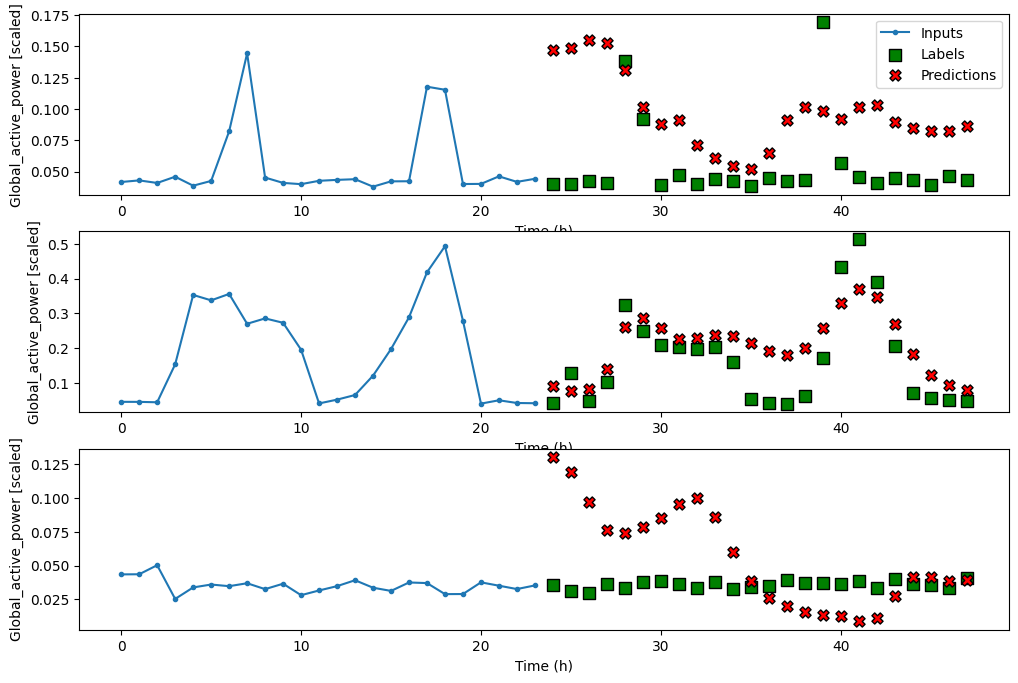

In [26]:
multi_window.plot(lstm_model)

Ahora vamos a implementar una red neuronal convolucional.

## Red neuronal convolucional (CNN)

Una red neuronal convolucional (CNN) utiliza la función de convolución para reducir el espacio de características. Esto filtra efectivamente nuestras series temporales y realiza la selección de características. Además, una CNN es más rápida de entrenar que un LSTM, ya que las operaciones están paralelizadas, mientras que el LSTM debe tratar un elemento de la secuencia a la vez.

Debido a que la operación de convolución reduce el espacio de características, debemos proporcionar una secuencia de entrada un poco más larga para asegurarnos de que la secuencia de salida contenga 24 intervalos de tiempo. Cuánto más larga necesita ser depende de la longitud del kernel que realiza la operación de convolución. En este caso, usaremos una longitud de kernel de 3. Esta es una elección arbitraria, así que siéntete libre de experimentar con diferentes valores, aunque tus resultados podrían diferir de lo que se muestra aquí. Dado que necesitamos 24 etiquetas, podemos calcular la secuencia de entrada utilizando la ecuación 18.1.

input length = label length + kernel length – 1


Esto nos obliga a definir una ventana de datos específicamente para el modelo CNN. Tenga en cuenta que, dado que estamos definiendo una nueva ventana de datos, el lote de muestras utilizado para el gráfico diferirá del que se ha utilizado hasta ahora.

In [27]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH,
                              label_width=LABEL_WIDTH, 
                              shift=24,
                              label_columns=['Global_active_power'])

A continuación, enviaremos la entrada a través de una capa Conv1D, que filtra la secuencia de entrada. Luego se alimenta a una capa densa con 32 neuronas para el aprendizaje antes de pasar a la capa de salida. Como siempre, entrenaremos el modelo y almacenaremos su rendimiento para comparación.

In [28]:
cnn_model = Sequential([
    Conv1D(32, activation='relu',kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)
val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0179 - mean_absolute_error: 0.0992 - val_loss: 0.0117 - val_mean_absolute_error: 0.0787
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0848 - val_loss: 0.0123 - val_mean_absolute_error: 0.0848
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0853 - val_loss: 0.0116 - val_mean_absolute_error: 0.0805
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0839 - val_loss: 0.0115 - val_mean_absolute_error: 0.0780
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0831 - val_loss: 0.0114 - val_mean_absolute_error: 0.0782
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0131 - mean_absolute_error: 0.0828 - val_loss: 0.0121 - val_mean_absolute_error: 0.0787
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0828 - v

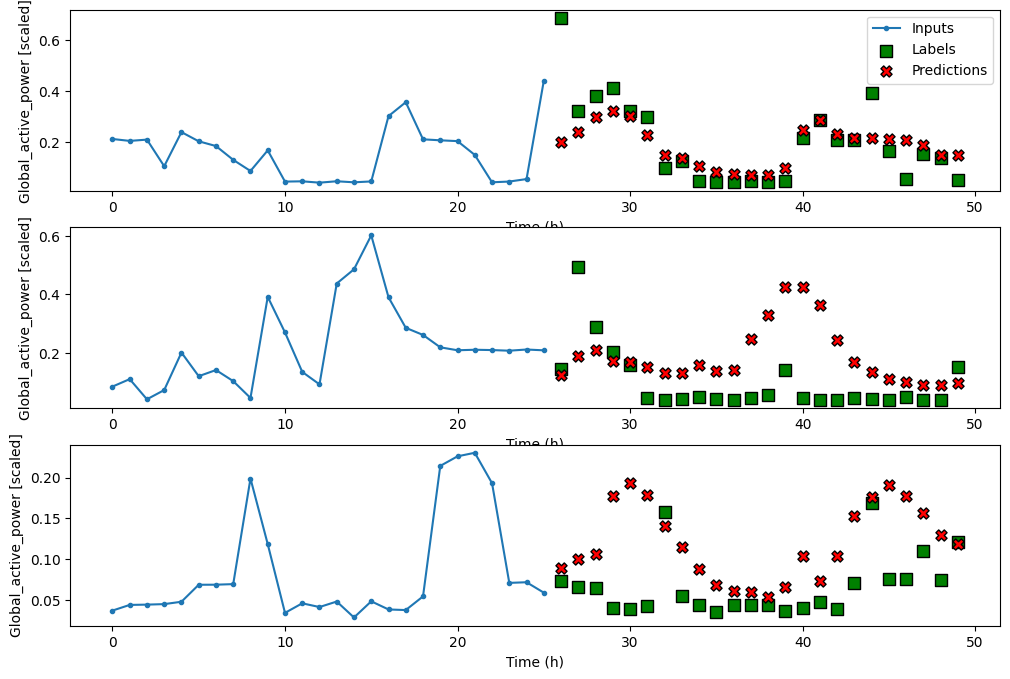

In [29]:
cnn_multi_window.plot(cnn_model)

Notarás en la figura 18.12 que la secuencia de entrada difiere de nuestros métodos anteriores porque trabajar con una CNN implica segmentar los datos nuevamente para tener en cuenta la longitud del kernel de convolución. Los conjuntos de entrenamiento, validación y prueba permanecen sin cambios, por lo que sigue siendo válido comparar el rendimiento de todos los modelos.

Ahora combinemos el modelo CNN con el modelo LSTM.

## Combinando una CNN con un LSTM

Sabemos que LSTM es bueno para tratar secuencias de datos, mientras que CNN puede filtrar una secuencia de datos. Por lo tanto, es interesante probar si filtrar una secuencia antes de alimentarla a un LSTM puede resultar en un modelo con mejor rendimiento.

Alimentaremos la secuencia de entrada a una capa Conv1D, pero esta vez usaremos una capa LSTM para aprender. Luego enviaremos la información a la capa de salida. Nuevamente, entrenaremos el modelo y almacenaremos su rendimiento.

In [30]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)
val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test,verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0183 - mean_absolute_error: 0.1008 - val_loss: 0.0126 - val_mean_absolute_error: 0.0800
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0135 - mean_absolute_error: 0.0845 - val_loss: 0.0116 - val_mean_absolute_error: 0.0786
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0132 - mean_absolute_error: 0.0832 - val_loss: 0.0116 - val_mean_absolute_error: 0.0778
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0131 - mean_absolute_error: 0.0826 - val_loss: 0.0115 - val_mean_absolute_error: 0.0772
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0130 - mean_absolute_error: 0.0824 - val_loss: 0.0116 - val_mean_absolute_error: 0.0788
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0129 - mean_absolute_error: 0.0820 - val_loss: 0.0113 - val_mean_absolute_error: 0.0795
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0129 - mean_absolute_error: 0.0818 - v

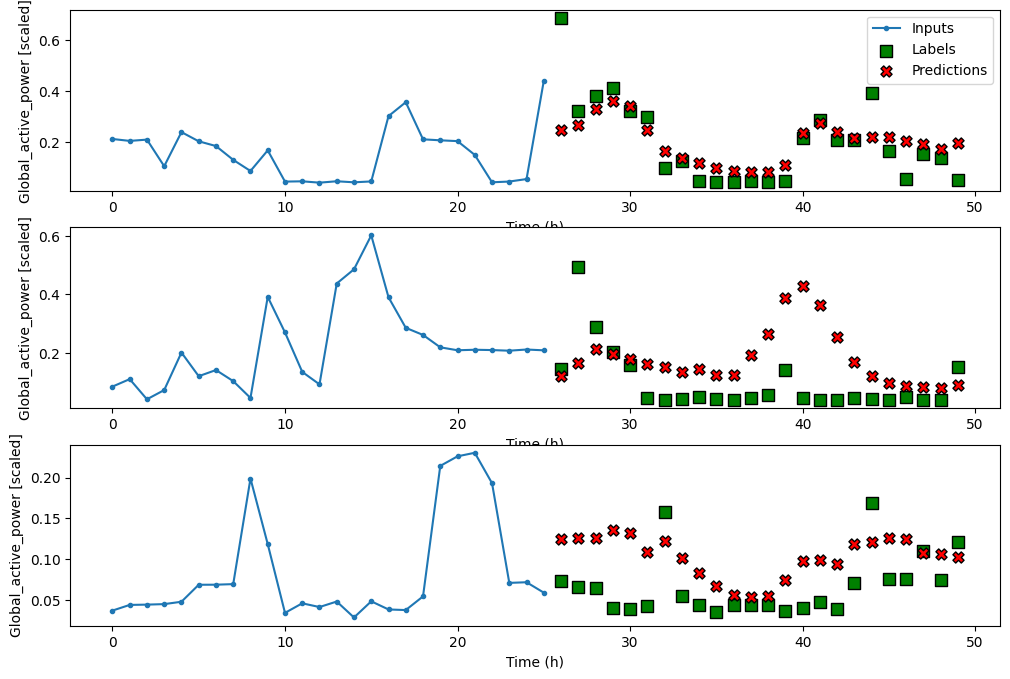

In [31]:
cnn_multi_window.plot(cnn_lstm_model)

Finalmente, implementemos un modelo LSTM autoregresivo.

## El modelo LSTM autorregresivo

El modelo final que implementaremos es un modelo LSTM autoregresivo (ARLSTM). En lugar de generar toda la secuencia de salida de una sola vez, el modelo autoregresivo generará una predicción a la vez y utilizará esa predicción como entrada para generar la siguiente. Este tipo de arquitectura está presente en los modelos de pronóstico de vanguardia, pero viene con una advertencia. Si el modelo genera una muy mala primera predicción, este error se trasladará a las siguientes predicciones, lo que amplificará los errores. No obstante, vale la pena probar este modelo para ver si funciona bien en nuestra situación.

El primer paso es definir la clase que implementa el modelo ARLSTM.

In [32]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):#1
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units) #2
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True) #3
        self.dense = Dense(train_df.shape[1]) #4
    
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs) #5
        prediction = self.dense(x) #6
        return prediction, state
    """
    Ahora que tenemos una forma de capturar la primera predicción, 
    podemos definir la función llamada call, que ejecutará un bucle 
    para generar la secuencia de predicciones con una longitud de out_steps. 
    Ten en cuenta que la función debe llamarse call porque es invocada implícitamente por Keras; 
    nombrarla de otra manera resultaría en un error.

    Dado que estamos usando la clase LSTMCell, que es una clase de bajo nivel, 
    debemos pasar manualmente el estado anterior. Una vez finalizado el ciclo, 
    apilamos nuestras predicciones y nos aseguramos de que tengan la forma de salida 
    correcta utilizando el método de transposición.
    """
    def call(self, inputs, training=None):
        predictions = [] #7
        prediction, state = self.warmup(inputs) #8
        predictions.append(prediction) #9
        for n in range(1, self.out_steps):
            x = prediction #10
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x) #11
            predictions.append(prediction)

        predictions = tf.stack(predictions) #12
        predictions = tf.transpose(predictions, [1, 0, 2]) #13
        return predictions


Luego podemos usar esta clase para inicializar nuestro modelo. Entrenaremos el modelo en la ventana múltiple y almacenaremos su rendimiento para comparación.

In [33]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)
history = compile_and_fit(AR_LSTM, multi_window)
val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0191 - mean_absolute_error: 0.1080 - val_loss: 0.0127 - val_mean_absolute_error: 0.0851
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0137 - mean_absolute_error: 0.0858 - val_loss: 0.0114 - val_mean_absolute_error: 0.0813
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0132 - mean_absolute_error: 0.0838 - val_loss: 0.0114 - val_mean_absolute_error: 0.0782
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0131 - mean_absolute_error: 0.0830 - val_loss: 0.0114 - val_mean_absolute_error: 0.0815
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0130 - mean_absolute_error: 0.0826 - val_loss: 0.0111 - val_mean_absolute_error: 0.0776
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0130 - mean_absolute_error: 0.0821 - val_loss: 0.0109 - val_mean_absolute_error: 0.0768
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0129 - mean_absolute_error: 0.0817 -

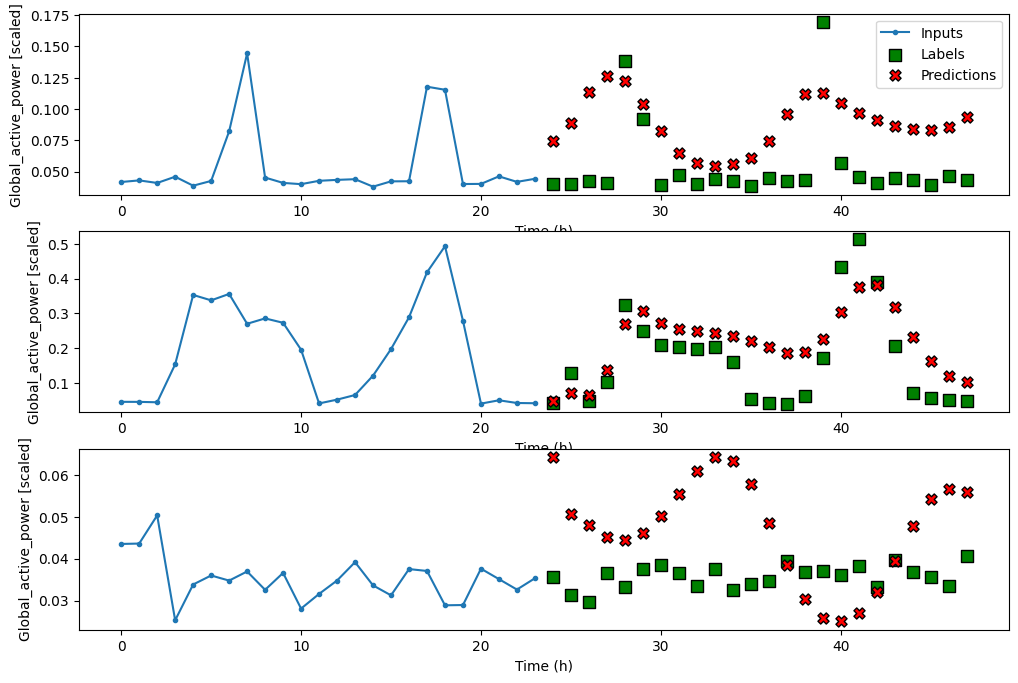

In [34]:
multi_window.plot(AR_LSTM)

Ahora que hemos construido una amplia variedad de modelos, seleccionemos el mejor basado en su MAE en el conjunto de prueba.

## Seleccionando el mejor modelo

Hemos construido muchos modelos para este proyecto, desde un modelo lineal hasta un modelo ARLSTM. Ahora visualicemos el MAE de cada modelo para determinar el campeón.


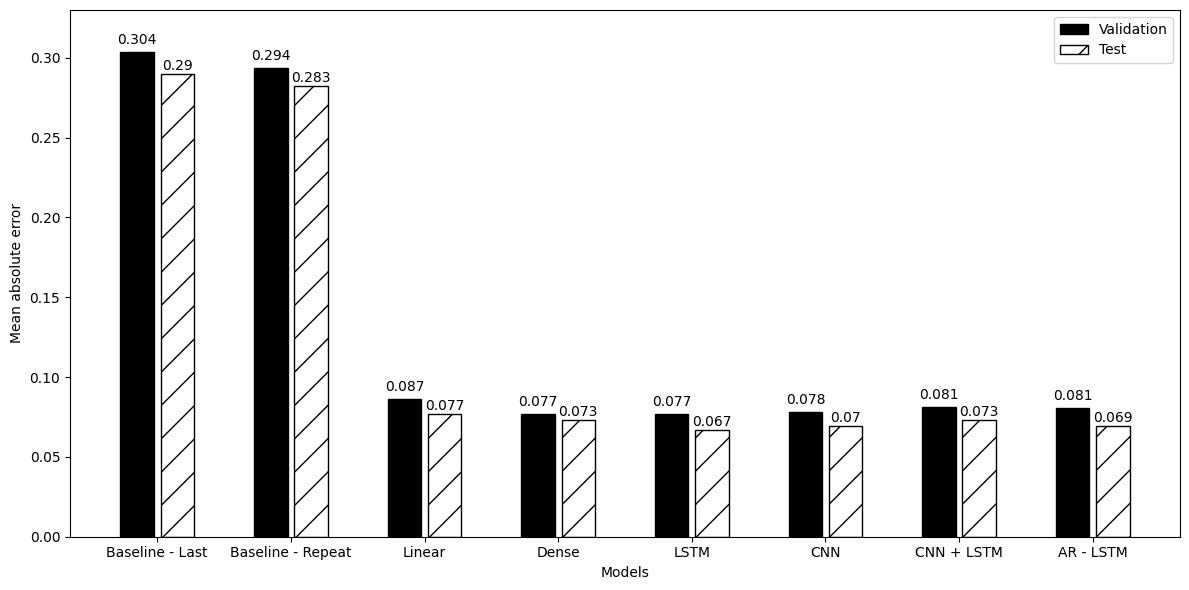

In [36]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))
fig, ax = plt.subplots(figsize=(12, 6)) 
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black',label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black',hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)),ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

La Figura 18.15 muestra que todos los modelos se desempeñaron mucho mejor que las líneas de base. Además, nuestro campeón es el modelo LSTM, ya que logró un MAE de 0.077 en el set de prueba, que es el MAE más bajo de todos. Por lo tanto, recomendamos utilizar este modelo para pronosticar la potencia activa global durante las próximas 24 horas.


## Proximos pasos

¡Felicitaciones por completar este proyecto final! Espero que haya tenido éxito al completarlo por su cuenta y que se sienta seguro de su conocimiento de previsión de series temporales mediante modelos de deep learning.

En el próximo capítulo, comenzaremos la parte final de este libro, donde automatizaremos el proceso de pronóstico. Hay muchas bibliotecas que pueden generar predicciones precisas con pasos mínimos, y a menudo se usan en la industria, lo que hace que esta sea una herramienta esencial para la previsión de series temporales. Veremos una biblioteca ampliamente utilizada llamada Prophet.